# Downloading the dataset

In [1]:
# pip install torch
# pip install torchvision

In [2]:
# !pip install wget

In [3]:
# !wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar
# !tar -xf wiki_crop.tar

In [4]:
import math
import os
import time
from datetime import datetime
from pathlib import Path
from glob import glob

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, utils
from PIL import Image
import numpy as np

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Prepare Data

In [5]:
def load_data(dataset='wiki', data_dir='./wiki_crop'):

    meta_path = Path(data_dir) / f'{dataset}.mat'
    meta = loadmat(meta_path)
    meta_data = meta[dataset][0, 0]

    full_path = meta_data['full_path'][0]
    full_path = [y for x in full_path for y in x]

    dob = meta_data['dob'][0]

    photo_taken = meta_data['photo_taken'][0]

    age = [calc_age(photo_taken[i], dob[i]) for i in range(len(dob))]
    
    clean_mapping = {pth:age for (pth, age) in zip(full_path, age) if age > 0}
    
    full_path = list(clean_mapping.keys())
    age = list(clean_mapping.values())

    return full_path, age

In [6]:
def calc_age(taken, dob):

    birth = datetime.fromordinal(max(int(dob) - 366, 1))

    if birth.month < 7:
        return taken - birth.year
    else:
        return taken - birth.year - 1

In [7]:
def scale(x, feature_range=(-1, 1)):
    
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [8]:
bins = [18, 29, 39, 49, 59]
def one_hot(x, bins):
    
    x = x.numpy()
    idxs = np.digitize(x, bins, right=True)
    idxs = idxs.reshape(-1,1)
    z = torch.zeros(len(x), len(bins)+1).scatter_(1, torch.tensor(idxs), 1)
    return z

# Data Loader

In [9]:
class ImageAgeDataset(Dataset):

    def __init__(self, dataset, data_dir, transform=None):
        
        self.data_dir = data_dir
        self.full_path, self.age = load_data(dataset, data_dir)
        self.transform = transform
    
    def __len__(self):
        return len(self.age)
    
    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.data_dir, self.full_path[idx]))
        age = self.age[idx]
        sample = {'image': image, 'age': age}
        if self.transform:
            sample = self.transform(sample)
        return sample

In [10]:
class Resize(object):
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        
    def __call__(self, sample):
        image, age = sample['image'], sample['age']
        image = transforms.Resize(self.output_size)(image)
        return {'image': image, 'age': age}

class ToTensor(object):

    def __call__(self, sample):
        image, age = sample['image'], sample['age']
        image = transforms.ToTensor()(image)
        if image.size()[0] == 1:
            image = image.expand(3,-1,-1)
        return {'image': image, 'age': age}

In [11]:
dataset='wiki'
data_dir='./wiki_crop'
bins = [18, 29, 39, 49, 59]
img_size = 64
batch_size = 128

tfms = transforms.Compose([Resize((img_size, img_size)),
                           ToTensor()])

train_dataset = ImageAgeDataset(dataset, data_dir, transform=tfms)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)

In [12]:
trainiter = iter(train_loader)
train = next(trainiter)

In [13]:
# # Get the image from the dataset
# image1 = train_dataset[0]['image'].numpy()

# # Convert the numpy array to PIL image
# image_pil = Image.fromarray(np.uint8(image1.transpose((1, 2, 0)) * 255))

# # Display the image
# image_pil.show()

In [14]:
# # Get the image from the dataset
# image2 = train_dataset[60941]['image'].numpy()

# # Convert the numpy array to PIL image
# image_pil = Image.fromarray(np.uint8(image2.transpose((1, 2, 0)) * 255))

# # Display the image
# image_pil.show()

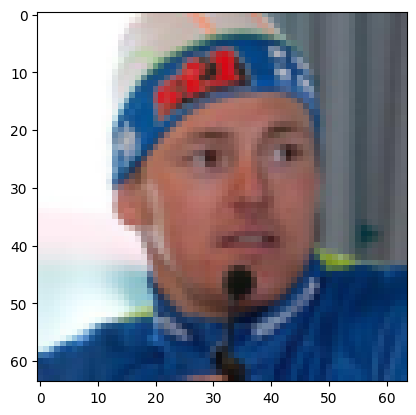

In [15]:
plt.imshow(train_dataset[0]['image'].numpy().transpose(1,2,0))

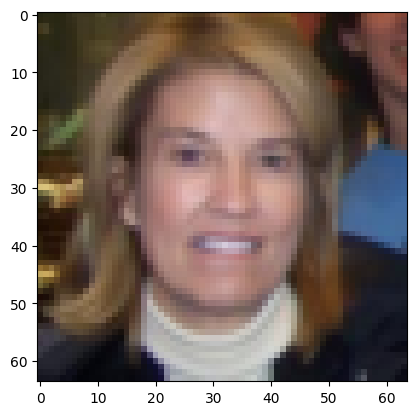

In [16]:
plt.imshow(train_dataset[60941]['image'].numpy().transpose(1,2,0))

In [17]:
from PIL import Image , ImageDraw

# dataiter = iter(train_loader)
# data = next(dataiter)
# images, labels = data['image'], data['age']

# fig = Image.new('RGB', (2500, 400))

# plot_size=20
# width = 125
# height = 200

# for idx in np.arange(plot_size):
#     img = np.transpose(images[idx], (1, 2, 0))
#     pil_img = Image.fromarray(np.uint8(img*255))
#     pil_img = pil_img.resize((width, height), Image.ANTIALIAS)
#     fig.paste(pil_img, (idx*width, 0))
#     draw = ImageDraw.Draw(fig)
#     draw.text((idx*width+10, height+10), str(labels[idx].item()), fill='black')

# fig.show()


In [18]:
# dataiter = iter(train_loader)
# data = next(dataiter)
# images, labels = data['image'], data['age']

# fig = plt.figure(figsize=(25, 4))
# plot_size=20
# for idx in np.arange(plot_size):
#     ax = fig.add_subplot(2, plot_size//2, idx+1, xticks=[], yticks=[])
#     ax.imshow(np.transpose(images[idx], (1, 2, 0)))
#     ax.set_title(str(labels[idx].item()))

# Define Models

## Discriminator

In [19]:
import torch.nn as nn
import torch.nn.functional as F

In [20]:
def conv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(conv_layer)
    
    if batch_norm:
        bn = nn.BatchNorm2d(out_channels)
        layers.append(bn)
        
    return nn.Sequential(*layers)

In [21]:
# class Discriminator(nn.Module):
#     def __init__(self, y_size, conv_dim=128):
#         super(Discriminator, self).__init__()
        
#         self.conv_dim = conv_dim
        
#         # Convolutional layers
#         self.conv1 = nn.Conv2d(3, conv_dim, 4, 2, 1)
#         self.conv2 = nn.Conv2d(conv_dim, conv_dim*2, 4, 2, 1)
#         self.conv3 = nn.Conv2d(conv_dim*2, conv_dim*4, 4, 2, 1)
#         self.conv4 = nn.Conv2d(conv_dim*4, conv_dim*8, 4, 2, 1)
#         self.conv5 = nn.Conv2d(conv_dim*8 + y_size, 1, 4, 1, 0)
        
#     def forward(self, x, y):
#         x = nn.LeakyReLU(0.2)(self.conv1(x))
#         x = nn.LeakyReLU(0.2)(self.conv2(x))
#         x = nn.LeakyReLU(0.2)(self.conv3(x))
#         x = nn.LeakyReLU(0.2)(self.conv4(x))
        
#         # Concatenate the condition y to the features
#         y = y.view(-1, y.size()[-1], 1, 1)
#         y = y.expand(-1, -1, x.size(2), x.size(3))
#         x = torch.cat([x, y], dim=1)
        
#         x = self.conv5(x)
        
#         return x


In [22]:
class Discriminator(nn.Module):
    
    def __init__(self, y_size, conv_dim=64):

        super(Discriminator, self).__init__()
        self.conv_dim = conv_dim
        self.y_size = y_size
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        self.conv2 = conv(conv_dim+y_size, conv_dim * 2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)
        self.conv5 = conv(conv_dim*8, 1, 4, 1, 0, batch_norm=False)
            
    def forward(self, x, y):

        x = F.relu(self.conv1(x))
        y = y.view(-1,y.size()[-1],1,1)
        y = y.expand(-1,-1,x.size()[-2], x.size()[-1])
        x = torch.cat([x, y], 1)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.conv5(x)
        
        return x

## Generator

In [23]:
def deconv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    
    layers = []
    t_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(t_conv)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [24]:
class Generator(nn.Module):
    
    def __init__(self, z_size, y_size, conv_dim=64):

        super(Generator, self).__init__()
        
        self.conv_dim = conv_dim
        
        self.t_conv1 = deconv(z_size+y_size, conv_dim*8, 4, 1, 0)
        self.t_conv2 = deconv(conv_dim*8, conv_dim*4, 4)
        self.t_conv3 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv4 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv5 = deconv(conv_dim, 3, 4, batch_norm=False)
        
    def forward(self, z, y):

        x = torch.cat([z, y], dim=1)
        x = x.view(-1, x.size()[-1], 1, 1)
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        x = F.relu(self.t_conv4(x))
        x = self.t_conv5(x)
        x = torch.tanh(x)
        
        return x

In [25]:
# class Generator(nn.Module):
#     def __init__(self, z_size, y_size, conv_dim=128):
#         super(Generator, self).__init__()
        
#         self.conv_dim = conv_dim
        
#         # Transposed convolutional layers
#         self.t_conv1 = nn.ConvTranspose2d(z_size + y_size, conv_dim*8, 4, 1, 0)
#         self.t_conv2 = nn.ConvTranspose2d(conv_dim*8, conv_dim*4, 4, 2, 1)
#         self.t_conv3 = nn.ConvTranspose2d(conv_dim*4, conv_dim*2, 4, 2, 1)
#         self.t_conv4 = nn.ConvTranspose2d(conv_dim*2, conv_dim, 4, 2, 1)
#         self.t_conv5 = nn.ConvTranspose2d(conv_dim, 3, 4, 2, 1)
        
#     def forward(self, z, y):
#         x = torch.cat([z, y], dim=1)
#         x = x.view(-1, x.size()[-1], 1, 1)
        
#         x = nn.ReLU()(self.t_conv1(x))
#         x = nn.ReLU()(self.t_conv2(x))
#         x = nn.ReLU()(self.t_conv3(x))
#         x = nn.ReLU()(self.t_conv4(x))
#         x = torch.tanh(self.t_conv5(x))
        
#         return x

In [26]:
# # Generator
# class Generator(nn.Module):
#     def __init__(self, z_dim, y_dim, image_size, num_channels):
#         super(Generator, self).__init__()
        
#         self.z_dim = z_dim
#         self.y_dim = y_dim
#         self.image_size = image_size
#         self.num_channels = num_channels
        
#         self.fc = nn.Sequential(
#             nn.Linear(z_dim + y_dim, 256 * 8 * 8),
#             nn.ReLU()
#         )
        
#         self.deconv_layers = nn.Sequential(
#             nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
            
#             nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
            
#             nn.ConvTranspose2d(64, num_channels, kernel_size=4, stride=2, padding=1),
#             nn.Tanh()
#         )

#     def forward(self, z, y):
#         zy = torch.cat([z, y], dim=1)
#         x = self.fc(zy)
#         x = x.view(x.size(0), 256, 8, 8)
#         x = self.deconv_layers(x)
#         return x

# # Discriminator
# class Discriminator(nn.Module):
#     def __init__(self, image_size, y_dim, num_channels):
#         super(Discriminator, self).__init__()
        
#         self.image_size = image_size
#         self.y_dim = y_dim
#         self.num_channels = num_channels
        
#         self.conv_layers = nn.Sequential(
#             nn.Conv2d(num_channels + y_dim, 64, kernel_size=4, stride=2, padding=1),
#             nn.LeakyReLU(0.2),
            
#             nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm2d(128),
#             nn.LeakyReLU(0.2),
            
#             nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm2d(256),
#             nn.LeakyReLU(0.2)
#         )
        
#         self.fc = nn.Sequential(
#             nn.Linear(256 * 8 * 8, 1),
#             nn.Sigmoid()
#         )

#     def forward(self, x, y):
#         y = y.view(-1, self.y_dim, 1, 1)
#         y = y.expand(-1, -1, self.image_size, self.image_size)
#         x = torch.cat([x, y], dim=1)
#         x = self.conv_layers(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)
#         return x

In [27]:
# import torch
# import torch.nn as nn

# # Define a Generator with increased capacity
# class Generator(nn.Module):
#     def __init__(self, z_size, y_size, conv_dim=256):
#         super(Generator, self).__init__()
#         self.conv_dim = conv_dim
#         self.y_size = y_size

#         # Fully connected layer
#         self.fc = nn.Sequential(
#             nn.Linear(z_size + y_size, conv_dim * 8 * 4 * 4),
#             nn.ReLU()
#         )

#         # Transposed convolutional layers
#         self.deconv_layers = nn.Sequential(
#             nn.ConvTranspose2d(conv_dim * 8, conv_dim * 4, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm2d(conv_dim * 4),
#             nn.ReLU(),

#             nn.ConvTranspose2d(conv_dim * 4, conv_dim * 2, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm2d(conv_dim * 2),
#             nn.ReLU(),

#             nn.ConvTranspose2d(conv_dim * 2, conv_dim, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm2d(conv_dim),
#             nn.ReLU(),

#             nn.ConvTranspose2d(conv_dim, 3, kernel_size=4, stride=2, padding=1),
#             nn.Tanh()
#         )

#     def forward(self, z, y):
#         zy = torch.cat([z, y], dim=1)
#         x = self.fc(zy)
#         x = x.view(x.size(0), self.conv_dim * 8, 4, 4)  # Reshape to match deconv layers
#         x = self.deconv_layers(x)
#         return x

# # Define a Discriminator with increased capacity
# class Discriminator(nn.Module):
#     def __init__(self, image_size, y_size, conv_dim=256):
#         super(Discriminator, self).__init__()
#         self.conv_dim = conv_dim
#         self.y_size = y_size

#         # Convolutional layers
#         self.conv_layers = nn.Sequential(
#             nn.Conv2d(3 + y_size, conv_dim, kernel_size=4, stride=2, padding=1),
#             nn.LeakyReLU(0.2),

#             nn.Conv2d(conv_dim, conv_dim * 2, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm2d(conv_dim * 2),
#             nn.LeakyReLU(0.2),

#             nn.Conv2d(conv_dim * 2, conv_dim * 4, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm2d(conv_dim * 4),
#             nn.LeakyReLU(0.2),

#             nn.Conv2d(conv_dim * 4, conv_dim * 8, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm2d(conv_dim * 8),
#             nn.LeakyReLU(0.2)
#         )

#         # Fully connected layer
#         self.fc = nn.Sequential(
#             nn.Linear(conv_dim * 8 * (image_size // 16) * (image_size // 16), 1)
#         )

#     def forward(self, x, y):
#         y = y.view(-1, self.y_size, 1, 1)
#         y = y.expand(-1, -1, x.size(2), x.size(3))
#         x = torch.cat([x, y], dim=1)
#         x = self.conv_layers(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)
#         return x


## Build complete network

In [28]:
# # Initialize the generator and discriminator
# z_dim = 100
# y_dim = 6
# image_size = 64
# num_channels = 3

# G = Generator(z_dim, y_dim, image_size, num_channels)
# D = Discriminator(image_size, y_dim, num_channels)

# print(D)
# print()
# print(G)

In [29]:
conv_dim = 128
z_size = 100
y_size = 6 

D = Discriminator(y_size, conv_dim)
G = Generator(z_size, y_size, conv_dim)

print(D)
print()
print(G)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(134, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv5): Sequential(
    (0): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)

Generator(
  (t_conv1): Sequential(
    (0): ConvTranspose2d(106, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps

## Discriminator and Generator Losses

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [31]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size)  
    labels = labels.to(device)
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    labels = labels.to(device)
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

In [32]:
import torch.optim as optim

lr = 0.0002
beta1=0.5
beta2=0.999

d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

## Training

In [33]:
def checkpoint(G, D, epoch, model, root_dir):
    target_dir = f'{root_dir}/{model}'
    os.makedirs(target_dir, exist_ok=True)
    G_path = os.path.join(target_dir, f'G_{epoch}.pkl')
    D_path = os.path.join(target_dir, f'D_{epoch}.pkl')
    torch.save(G.state_dict(), G_path)
    torch.save(D.state_dict(), D_path)

def oh_to_class(fixed_y):
    age_map = {0:'0-18',1:'19-29',2:'30-39',3:'40-49',4:'50-59',5:'60+'}
    if torch.cuda.is_available():
        fixed_y = fixed_y.cpu()
    fixed_y_idxs = fixed_y.numpy().nonzero()[1]
    fixed_y_ages = [age_map[idx] for idx in fixed_y_idxs]
    
    return fixed_y_ages

def save_samples_ages(samples, fixed_y, model, root_dir):
    fixed_y_ages = oh_to_class(fixed_y)
    samples_ages = {'samples': samples, 'ages': fixed_y_ages}
    target_dir = f'{root_dir}/{model}'
    os.makedirs(target_dir, exist_ok=True)
    with open(f'{target_dir}/train_samples_ages.pkl', 'wb') as f:
        pkl.dump(samples_ages, f)

In [34]:
root_dir = "D:\study\Project\TARP project\MissingChildIdentification-main\MissingChildIdentification-main\content\Age-cGAN"

In [35]:
import os
import numpy as np
import torch
import pickle as pkl

model = 'GAN_mod_1'
os.makedirs(root_dir, exist_ok=True)

G.to(device)
D.to(device)

num_epochs = 50

samples = []
losses = []

print_every = 300

sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()
fixed_y = np.random.randint(len(bins), size=sample_size)
fixed_y = fixed_y.reshape(-1,1)
fixed_y = torch.zeros(sample_size, len(bins)+1).scatter_(1, torch.tensor(fixed_y, dtype=torch.long), 1)

for epoch in range(num_epochs):
    
    for batch_i, batch in enumerate(train_loader):
                
        batch_size = batch['image'].size(0)
        
        real_images = scale(batch['image'])
        
        ages = one_hot(batch['age'], bins)
        
        d_optimizer.zero_grad()
        
        real_images = real_images.to(device)
        ages = ages.to(device)
        
        D_real = D(real_images, ages)
        d_real_loss = real_loss(D_real)
        
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        z = z.to(device)
        fake_images = G(z, ages)
                   
        D_fake = D(fake_images, ages)
        d_fake_loss = fake_loss(D_fake)
        
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        g_optimizer.zero_grad()
        
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        z = z.to(device)
        fake_images = G(z, ages)
        
        D_fake = D(fake_images, ages)
        g_loss = real_loss(D_fake)
        
        g_loss.backward()
        g_optimizer.step()

        if batch_i % print_every == 0:
            losses.append((d_loss.item(), g_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    G.eval() 
    fixed_z = fixed_z.to(device)
    fixed_y = fixed_y.to(device)
    samples_z = G(fixed_z, fixed_y)
    samples.append(samples_z.detach().cpu().numpy())
    G.train() 
    
    # Save the model and optimizer state dicts
    checkpoint(G, D, epoch, model, root_dir)

# Save the samples and losses arrays
samples_file = os.path.join(root_dir, f'{model}_samples.pkl')
losses_file = os.path.join(root_dir, f'{model}_losses.pkl')
with open(samples_file, 'wb') as f:
    pkl.dump(samples, f)
with open(losses_file, 'wb') as f:
    pkl.dump(losses, f)

# Save the final model and optimizer state dicts
checkpoint(G, D, num_epochs, model, root_dir)

# Save the final samples array
save_samples_ages(samples, fixed_y, model, root_dir)


Epoch [    1/   50] | d_loss: 1.4355 | g_loss: 3.2672
Epoch [    1/   50] | d_loss: 1.5043 | g_loss: 1.2311
Epoch [    2/   50] | d_loss: 1.0227 | g_loss: 0.9211
Epoch [    2/   50] | d_loss: 1.7063 | g_loss: 4.6928
Epoch [    3/   50] | d_loss: 0.5703 | g_loss: 2.1789
Epoch [    3/   50] | d_loss: 0.3203 | g_loss: 3.7650
Epoch [    4/   50] | d_loss: 0.4354 | g_loss: 2.2745
Epoch [    4/   50] | d_loss: 0.2567 | g_loss: 2.9555
Epoch [    5/   50] | d_loss: 0.3165 | g_loss: 1.9225
Epoch [    5/   50] | d_loss: 0.2673 | g_loss: 4.6608
Epoch [    6/   50] | d_loss: 0.9255 | g_loss: 7.3792
Epoch [    6/   50] | d_loss: 0.3136 | g_loss: 3.8325
Epoch [    7/   50] | d_loss: 0.6793 | g_loss: 2.6556
Epoch [    7/   50] | d_loss: 0.2302 | g_loss: 3.8434
Epoch [    8/   50] | d_loss: 0.2235 | g_loss: 3.6417
Epoch [    8/   50] | d_loss: 0.0909 | g_loss: 4.1982
Epoch [    9/   50] | d_loss: 0.2393 | g_loss: 2.8023
Epoch [    9/   50] | d_loss: 0.1503 | g_loss: 4.7669
Epoch [   10/   50] | d_loss

In [36]:
# # Initialize the generator and discriminator
# z_dim = 100
# y_dim = 10
# image_size = 64
# num_channels = 3

# generator = Generator(z_dim, y_dim, image_size, num_channels)
# discriminator = Discriminator(image_size, y_dim, num_channels)

# # Define loss functions and optimizers
# criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
# g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
# d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# # Training loop (simplified)
# num_epochs = 100
# for epoch in range(num_epochs):
#     for real_images, condition in dataloader:  # Replace with your data loader
#         # Train Discriminator
#         real_labels = torch.ones(batch_size, 1)
#         fake_labels = torch.zeros(batch_size, 1)

#         # Generate fake images
#         z = torch.randn(batch_size, z_dim)
#         fake_images = generator(z, condition)

#         # Discriminator forward pass for real and fake images
#         real_outputs = discriminator(real_images, condition)
#         fake_outputs = discriminator(fake_images.detach(), condition)

#         # Calculate discriminator loss
#         d_loss_real = criterion(real_outputs, real_labels)
#         d_loss_fake = criterion(fake_outputs, fake_labels)
#         d_loss = d_loss_real + d_loss_fake

#         # Update discriminator
#         d_optimizer.zero_grad()
#         d_loss.backward()
#         d_optimizer.step()

#         # Train Generator
#         # Generate fake images again
#         z = torch.randn(batch_size, z_dim)
#         fake_images = generator(z, condition)

#         # Discriminator forward pass for fake images (again)
#         fake_outputs = discriminator(fake_images, condition)

#         # Calculate generator loss
#         g_loss = criterion(fake_outputs, real_labels)

#         # Update generator
#         g_optimizer.zero_grad()
#         g_loss.backward()
#         g_optimizer.step()

In [39]:
#Generating losses
import numpy as np

losses = np.array(losses)
d_losses = losses.T[0]
g_losses = losses.T[1]
avg_d_loss = np.mean(d_losses)
avg_g_loss = np.mean(g_losses)
print('Average Discriminator Loss: {:.4f}'.format(avg_d_loss))
print('Average Generator Loss: {:.4f}'.format(avg_g_loss))


Average Discriminator Loss: 0.2429
Average Generator Loss: 5.6173


In [38]:
torch.save(G.state_dict(), os.path.join(root_dir, model+'9_G.pth'))
torch.save(D.state_dict(), os.path.join(root_dir, model+'9_D.pth'))